In [1]:
from notebook_util_mine import *
%matplotlib inline

In [2]:
from mine import Mine

In [3]:
from minee.data.mix_gaussian import MixedGaussian

## Data

In [4]:
np.random.seed(1)
sample_size = 400
rho1 = 0.9
data = MixedGaussian(sample_size=sample_size,rho1=rho1).data
data_t = torch.Tensor(data)

Separate X data and Y data for the estimation. This should be a preprocessing done before instead of after feeding the data to the model.

In [5]:
X = data[:,[0]]
Y = data[:,[1]]

Generate the reference samples by resampling.

Text(0.5,1,'Plot of data samples')

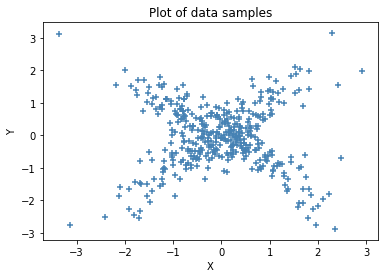

In [6]:
plt.scatter(X,Y,label="data",marker="+",color="steelblue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of data samples')

## MI estimation

### Choice of parameters

In [7]:
batch_size = int(sample_size*1)
lr = 1e-3
ma_rate = 0.1
fname = 'mine.pt' # file to load/save the results

### Initialization

In [8]:
mine = Mine(X,Y,batch_size=batch_size,lr=lr,ma_rate=ma_rate)

In [9]:
XY_net_list = []
dXY_list = []

### Training
Automatically load previous results from db file if exists

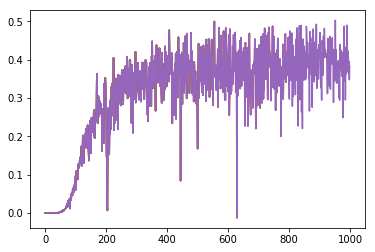

KeyboardInterrupt: 

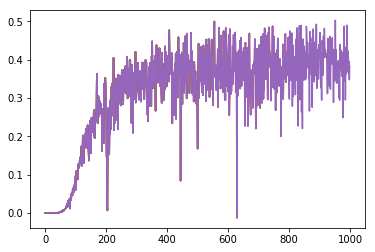

In [11]:
rerun = True
if not rerun and os.path.exists(fname):
    with open(fname,'rb') as f:
        checkpoint = torch.load(fname,map_location = "cuda" if torch.cuda.is_available() else "cpu")
        XY_net_list = checkpoint['XY_net_list']
        dXY_list = checkpoint['dXY_list']
        XY_net.load_state_dict(XY_net_list[-1])
        print('results loaded from '+fname)
        plt.plot(dXY_list)
else:
    for j in range(50):
        for i in range(200):
            mine.step()    
            dXY_list = np.append(dXY_list, mine.forward())
        #XY_net_list = np.append(XY_net_list,copy.deepcopy(XY_net.state_dict()))

        # To show intermediate works
        plt.plot(dXY_list)
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

To save new results to a db file using the following code, delete the existing db file.

In [ ]:
replace_file = False
if replace_file or not os.path.exists(fname):
    with open(fname,'wb') as f:
        torch.save({
            'dXY_list' : dXY_list,
            'XY_net_list' : XY_net_list
        },f)
        #dill.dump([XY_net_list,X_net_list,Y_net_list,dXY_list,dX_list,dY_list],f)
        print('results saved to '+fname)

## Analysis

In [ ]:
mi_list = dXY_list
plt.plot(mi_list[:6400])
plt.title("Plot of MI estimates against number iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")

In [20]:
XY_net_ = copy.deepcopy(XY_net)

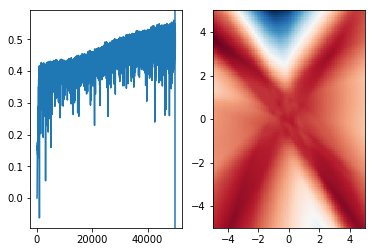

In [22]:
T = mi_list.size # total number of iteractions
dt = T // XY_net_list.shape[0] # period for each snapshot of the NN
@interact(t=(dt,T,dt))
def f(t=T):
    plt.subplot(121)
    plt.plot(mi_list)
    plt.axvline(t)
    plt.subplot(122)
    XY_net_.load_state_dict(XY_net_list[(t // dt) - 1])
    plot_net_2(XY_net_)
    plt.show()

0.5142724752426148


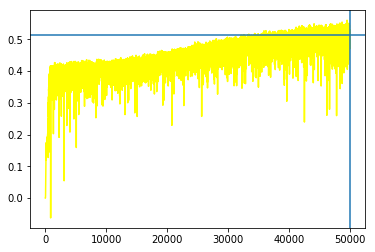

In [23]:
@interact(t=(100,T,100))
def f(t=T):
    w = 50
    plt.plot(mi_list,color='yellow')
    mi = mi_list[:t+1][-w:].mean()
    plt.axhline(mi)
    plt.axvline(t)
    print(mi)